## Deep Learning Lab.

In this lab we will continue working with the CIFAR-10 dataset. However, we will go deeper. Adding linear layers and non-linear activations functions on top of each other. First, I will present a re-implementation of what we had last time.

### 1. Implementing our own Softmax + CrossEntropyLoss function.
This is similar to the loss_softmax and loss_softmax_backward implementations in the previous lab. Here we also make sure this works for a batch of vectors instead of a single vector. This means the input here will be a tensor of size batchSize x inputSize:

In [6]:
import torch, lab_utils, random
from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import json, string

#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
%matplotlib inline

In [5]:
# Verify GPU visibility
!nvidia-smi

Thu Sep 28 16:46:40 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:09:00.0     Off |                  N/A |
| 23%   38C    P8    17W / 250W |      3MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# This class combines Softmax + Cross Entropy Loss.
# Similar to the previous lab, but this implementation works for batches of inputs and
# not just individual input vectors. Here the input is batchSize x inputSize.
class nn_CrossEntropyLoss(object): 
    # Forward pass -log softmax(input_{label})
    def forward(self, inputs, labels):
        max_val = inputs.max()  # This is to avoid variable overflows.
        exp_inputs = (inputs - max_val).exp()
        # This is different than in the previous lab. Avoiding for loops here.
        denominators = exp_inputs.sum(1).repeat(inputs.size(1), 1).t()
        self.predictions = torch.mul(exp_inputs, 1 / denominators)
        # Check what gather does. Just avoiding another for loop.
        return -self.predictions.log().gather(1, labels.view(-1, 1)).mean()
    
    # Backward pass 
    def backward(self, inputs, labels):
        grad_inputs = self.predictions.clone()
        # Ok, Here we will use a for loop (but it is avoidable too).
        for i in range(0, inputs.size(0)):
            grad_inputs[i][labels[i]] = grad_inputs[i][labels[i]] - 1
        return grad_inputs 

# Input: 4 vectors of size 10.
testInput = torch.Tensor(4, 10).normal_(0, 0.1)
# labels: 4 labels indicating the correct class for each input.
labels = torch.LongTensor([3, 4, 4, 8])

# Forward and Backward passes:
loss_softmax = nn_CrossEntropyLoss()
loss = loss_softmax.forward(testInput, labels)
gradInputs = loss_softmax.backward(testInput, labels)

Before continuing, make sure you understand every line of code in the above implementation by looking at previous lecture notes. 

### 2. Implementing our own Linear layer.
Next we provide an implementation for a linear layer that is also meant to work on batches of vetors. Notice that in addition of computing gradWeight and gradBias, we require here gradInput as we might need this gradient to do backpropagation. Making a batched implementation of this layer is easier because the only change is that now we have matrix-matrix multiplications as opposed to vector-matrix multiplications.

In [3]:
class nn_Linear(object):
    def __init__(self, inputSize, outputSize):
        self.weight = torch.Tensor(inputSize, outputSize).normal_(0, 0.01)
        self.gradWeight = torch.Tensor(inputSize, outputSize)
        self.bias = torch.Tensor(outputSize).zero_()
        self.gradBias = torch.Tensor(outputSize)
    
    # Forward pass, inputs is a matrix of size batchSize x inputSize
    def forward(self, inputs):
        # This one needs no change, it just becomes matrix x matrix multiplication
        # as opposed to just vector x matrix multiplication as we had before.
        return torch.matmul(inputs, self.weight) + self.bias
    
    # Backward pass, in addition to compute gradients for the weight and bias.
    # It has to compute gradients with respect to inputs. 
    def backward(self, inputs, gradOutput):
        self.gradWeight = torch.matmul(inputs.t(), gradOutput)
        self.gradBias = gradOutput.sum(0)
        return torch.matmul(gradOutput, self.weight.t())

# Input: 4 vectors of size 3072.
testInput = torch.Tensor(4, 3 * 32 * 32).normal_(0, 0.1)
dummyGradOutputs = torch.Tensor(4, 10).normal_(0, 0.1)

#Forward and Backward passes:
linear = nn_Linear(3 * 32 * 32, 10)
output = linear.forward(testInput)
gradInput = linear.backward(testInput, dummyGradOutputs)

### 3. Implementing an "Activation" function, or non-linearity.
Finally we need to implement some non-linear activation function. Here we will implement ReLU which is the simplest activation function but also one of the most important as we discussed during class.

In [4]:
class nn_ReLU(object):
    # pytorch has an element-wise max function.
    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[outputs < 0] = 0
        return outputs
    
    # Make sure the backward pass is absolutely clear.
    def backward(self, inputs, gradOutput):
        gradInputs = gradOutput.clone()
        gradInputs[inputs < 0] = 0
        return gradInputs

### 4. Implementation I: CIFAR-10 Neural network classification using our implementations.
Ok, now we are ready to use our three layers to build a neural network. We will use it to classify images on CIFAR-10 as in our previous lab, but additionally we will use pytorch's DataLoaders which will build batches automatically for us, and will shuffle the data for us.

In [32]:
# In addition to transforming the image into a tensor, we also normalize the values in the image
# so that the mean pixel value is subtracted and divided by the pixel standard deviation.

imgTransform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), # RGB mean
                                                        (0.2023, 0.1994, 0.2010)), # RGB std
                                   transforms.Lambda(lambda inputs: inputs.view(3 * 32 * 32))])

trainset = CIFAR10(root='../data', train = True, transform = imgTransform, download=False)
valset = CIFAR10(root='../data', train = False, transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = 128, 
                                          shuffle = True, 
                                          num_workers = 0
                                         )
valLoader = torch.utils.data.DataLoader(valset, 
                                        batch_size = 128, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )

#---
# I don't understand this:
# transforms.Normalize((0.4914, 0.4822, 0.4465),0.2023, 0.1994, 0.2010))...

Now that the dataset train, and validation splits are loaded, let's train.

In [35]:
from tqdm import tqdm as tqdm
# Try this if the above gives trouble: 
#from tqdm import tqdm_notebook as tqdm

learningRate = 1e-4  # Single learning rate for this lab.

# Definition of our network.
# --------------------------

linear1 = nn_Linear(3 * 32 * 32, 1024)
relu = nn_ReLU()
linear2 = nn_Linear(1024, 10)
criterion = nn_CrossEntropyLoss()

# Training loop.
# -------------

for epoch in range(0, 10):
    
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
    
    for (i, (inputs, labels)) in enumerate(t):
    
        # Forward pass:
        a = linear1.forward(inputs)
        b = relu.forward(a)
        c = linear2.forward(b)
        cum_loss += criterion.forward(c, labels)
        max_scores, max_labels = c.max(1)
        correct += (max_labels == labels).sum()
        
        # Backward pass:
        grads_c = criterion.backward(c, labels)
        grads_b = linear2.backward(b, grads_c)
        grads_a = relu.backward(a, grads_b)
        linear1.backward(inputs, grads_a)
        
        # Weight and bias updates.
        linear1.weight = linear1.weight - learningRate * linear1.gradWeight
        linear1.bias = linear1.bias - learningRate * linear1.gradBias
        linear2.weight = linear2.weight - learningRate * linear2.gradWeight
        linear2.bias = linear2.bias - learningRate * linear2.gradBias
        
        # logging information.
        t.set_postfix(loss = cum_loss / (1 + i), accuracy = correct / (1 + i))
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
    for (i, (inputs, labels)) in enumerate(t):
        
        # Forward pass:
        a = linear1.forward(inputs)
        b = relu.forward(a)
        c = linear2.forward(b)
        cum_loss += criterion.forward(c, labels)
        max_scores, max_labels = c.max(1)
        correct += (max_labels == labels).sum()
        
        # logging information.
        t.set_postfix(loss = cum_loss / (1 + i), accuracy = correct / (1 + i))    




Training epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 0:   0%|          | 0/391 [00:00<?, ?it/s, accuracy=10, loss=2.32]

Training epoch 0:   0%|          | 0/391 [00:00<?, ?it/s, accuracy=16, loss=2.29]

Training epoch 0:   0%|          | 0/391 [00:00<?, ?it/s, accuracy=20.7, loss=2.28]

Training epoch 0:   1%|          | 3/391 [00:00<00:16, 23.67it/s, accuracy=20.7, loss=2.28]

Training epoch 0:   1%|          | 3/391 [00:00<00:21, 18.40it/s, accuracy=22, loss=2.26]

Training epoch 0:   1%|          | 3/391 [00:00<00:25, 15.11it/s, accuracy=23.2, loss=2.25]

Training epoch 0:   1%|          | 3/391 [00:00<00:30, 12.88it/s, accuracy=24, loss=2.24]

Training epoch 0:   2%|▏         | 6/391 [00:00<00:15, 24.87it/s, accuracy=24, loss=2.24]  

Training epoch 0:   2%|▏         | 6/391 [00:00<00:17, 22.57it/s, accuracy=24.6, loss=2.23]

Training epoch 0:   2%|▏         | 6/391 [00:00<00:19, 20.18it/s, accuracy=25.2, loss=2.22]

Training epoch 0:   2%|▏         | 6/391

Training epoch 0:  17%|█▋        | 66/391 [00:01<00:09, 34.75it/s, accuracy=36.8, loss=2.04]

Training epoch 0:  17%|█▋        | 66/391 [00:02<00:09, 32.70it/s, accuracy=37, loss=2.03]

Training epoch 0:  17%|█▋        | 66/391 [00:02<00:10, 32.25it/s, accuracy=37, loss=2.03]

Training epoch 0:  17%|█▋        | 66/391 [00:02<00:10, 31.81it/s, accuracy=37.2, loss=2.03]

Training epoch 0:  17%|█▋        | 66/391 [00:02<00:10, 31.38it/s, accuracy=37.3, loss=2.03]

Training epoch 0:  18%|█▊        | 70/391 [00:02<00:09, 34.84it/s, accuracy=37.3, loss=2.03]

Training epoch 0:  18%|█▊        | 70/391 [00:02<00:09, 32.83it/s, accuracy=37.4, loss=2.02]

Training epoch 0:  18%|█▊        | 70/391 [00:02<00:09, 32.39it/s, accuracy=37.6, loss=2.02]

Training epoch 0:  18%|█▊        | 70/391 [00:02<00:10, 31.96it/s, accuracy=37.7, loss=2.02]

Training epoch 0:  18%|█▊        | 70/391 [00:02<00:10, 31.55it/s, accuracy=37.8, loss=2.02]

Training epoch 0:  19%|█▉        | 74/391 [00:02<00:09, 34.77it/

Training epoch 0:  84%|████████▍ | 330/391 [00:09<00:01, 34.03it/s, accuracy=46.7, loss=1.82]


Training epoch 0:  91%|█████████ | 354/391 [00:10<00:01, 34.81it/s, accuracy=47.2, loss=1.81]

297/|/ 76%|| 297/391 [00:23<00:07, 12.40it/s, accuracy=61.2, loss=1.51]


Validation epoch 9: 100%|██████████| 79/79 [00:01<00:00, 56.42it/s, accuracy=67.8, loss=1.33]


### 5. Implementation II: CIFAR-10 neural network classification using pytorch's nn functions.
Pytorch already comes with an impressive number of operations used to implement deep neural networks. Here we will use the same ones that we already have implemented and show how similar and easy is to use pytorch's implementations. Another thing about pytorch is that we will wrap our variables in a neural network with a torch.autograd.Variable object.

In [37]:
from tqdm import tqdm as tqdm
# Try this if the above gives trouble:
#from tqdm import tqdm_notebook as tqdm
learningRate = 1e-2  # Single learning rate for this lab.

# Definition of our network.
# --------------------------

network = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
).cuda()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()  # i believe this should have .cuda() as well

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train model
# -----------

def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10):
    
    # Training loop.
    for epoch in range(0, n_epochs):
        
        correct = 0.0
        cum_loss = 0.0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs).cuda()
            labels = Variable(labels).cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = correct / (1 + i))

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs).cuda()
            labels = Variable(labels).cuda()  # you can also put .cuda() within Variable args

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = correct / (1 + i))   
            
# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)

Training epoch 1:  13%|█▎        | 49/391 [00:00<00:05, 63.19it/s, accuracy=58.3, loss=1.6] 

68/|/ 17%|| 68/391 [00:13<01:02,  5.18it/s, accuracy=65.1, loss=1.43]

Validation epoch 9: 100%|██████████| 79/79 [00:01<00:00, 68.59it/s, accuracy=66.9, loss=1.35]


### 5. Implementation III: CIFAR-10 neural network classification using pytorch's autograd magic!
Objects of type `torch.autograd.Variable` contain two attributes .data and .grad, the first one, .data, contains the value of the variable at any given point, and .grad contains the value of the gradient of this variable once a backward call involving this variable has been invoked. In the previous code, we have to take into account that most torch tensor operations that can be applied to tensors, can also be applied to tensors wrapped into `torch.autograd.Variables`. 

The output of torch operations involving variables will also be a `torch.autograd.Variable` (as opposed to just a tensor). Another difference is that pytorch will record the operations on each `torch.autograd.Variable` in a graph structure so that gradients can be computed when a backward() call is performed on any variable in the graph. This very powerful technique is often called <b>"automatic differentiation"</b>. This means that as long as we wrap tensors in variables, and use pytorch operators, we do not really need to implement backward passes.

In [39]:
from tqdm import tqdm as tqdm
# Try this if the above gives trouble: 
#from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

learningRate = 1e-2  # Single learning rate for this lab.

class MyAutogradModel(nn.Module):
    def __init__(self):
        super(MyAutogradModel, self).__init__()
        # See documentation for nn.Parameter here:
        # https://github.com/pytorch/pytorch/blob/master/torch/nn/parameter.py
        self.weight1 = nn.Parameter(torch.Tensor(3072, 1024).normal_(0, 0.01))
        self.bias1 = nn.Parameter(torch.Tensor(1024).zero_())
        self.weight2 = nn.Parameter(torch.Tensor(1024, 10).normal_(0, 0.01))
        self.bias2 = nn.Parameter(torch.Tensor(10).zero_())
        
    # No need to implement backward when using torch.autograd.Variable and pytorch functions.
    # Think of the possibilities!
    def forward(self, inputs):
        x = F.relu(torch.matmul(inputs, self.weight1) + self.bias1)
        x = torch.matmul(x, self.weight2) + self.bias2
        return x
        
# Definition of our network.
network = MyAutogradModel().cuda()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()  # I believe you can also put .cuda() here

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)

Training epoch 1:   5%|▌         | 20/391 [00:00<00:06, 53.94it/s, accuracy=53, loss=1.68]7]

363/|/ 93%|| 363/391 [00:22<00:01, 16.44it/s, accuracy=46.3, loss=1.84]

Validation epoch 9: 100%|██████████| 79/79 [00:01<00:00, 64.42it/s, accuracy=66.1, loss=1.36]


### 6. Convolutional Neural Networks (using Pytorch nn's)

In this section we will use <u>convolutional layers</u> in addition to linear layers. Convolutional layers work on 2D input so we will modify our data loaders so that they return 2D images instead of the flattened array versions of the images that we have been using thus far. 

In [40]:
# Same transformations as before but we do not vectorize the images.
imgTransform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])

trainset = CIFAR10(root='../data', train = True, transform = imgTransform)
valset = CIFAR10(root='../data', train = False, transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = 128, 
                                          shuffle = True, 
                                          num_workers = 0
                                         )
valLoader = torch.utils.data.DataLoader(valset, 
                                        batch_size = 128, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )

Once data is loaded, now we proceed to define and train our neural network. Notice how we only need to change the definition of the model and not the way it is trained. This is just another of many advantages of training with a framework built on well engineered practices.

(This network is taken from Yann Lecun's '98 paper on digit classification: http://yann.lecun.com/exdb/lenet/)



In [41]:
from tqdm import tqdm as tqdm
# Try this if the above gives trouble: 
#from tqdm import tqdm_notebook as tqdm

learningRate = 1e-2  # Single learning rate for this lab.

# LeNet is French for The Network, and is taken from Yann Lecun's 98 paper
# on digit classification http://yann.lecun.com/exdb/lenet/

# This was also a network with just two convolutional layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional layers. (input_channels,output_channels,kernel_size,stride=1,padding=0)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        
        
# Definition of our network.
network = LeNet().cuda()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 20)

Validation epoch 19: 100%|██████████| 79/79 [00:01<00:00, 67.00it/s, accuracy=75.9, loss=1.15]


The last model achieved some more impressive numbers than the 40% we were obtaining in our previous lab by a large margin. The last model seems to be still improving, maybe training it for more epochs, or under a different learning rate, or reducing the learning rate after the first 20 epochs, could improve the accuracy further. We could try all these things. We should also from time to time, test our model on a few inputs and see how good it is becoming.

Image 991


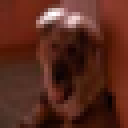

Image predicted as dog with confidence 0.32
y_hat[airplane] = 0.00
y_hat[automobile] = 0.02
y_hat[bird] = 0.15
y_hat[cat] = 0.28
y_hat[deer] = 0.03
y_hat[dog] = 0.32
y_hat[frog] = 0.11
y_hat[horse] = 0.06
y_hat[ship] = 0.00
y_hat[truck] = 0.02
Image 2498


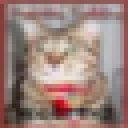

Image predicted as dog with confidence 0.43
y_hat[airplane] = 0.01
y_hat[automobile] = 0.01
y_hat[bird] = 0.06
y_hat[cat] = 0.26
y_hat[deer] = 0.02
y_hat[dog] = 0.43
y_hat[frog] = 0.07
y_hat[horse] = 0.02
y_hat[ship] = 0.08
y_hat[truck] = 0.03
Image 4897


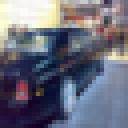

Image predicted as automobile with confidence 0.68
y_hat[airplane] = 0.16
y_hat[automobile] = 0.68
y_hat[bird] = 0.00
y_hat[cat] = 0.01
y_hat[deer] = 0.00
y_hat[dog] = 0.00
y_hat[frog] = 0.00
y_hat[horse] = 0.00
y_hat[ship] = 0.01
y_hat[truck] = 0.14
Image 6593


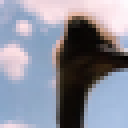

Image predicted as dog with confidence 0.45
y_hat[airplane] = 0.01
y_hat[automobile] = 0.00
y_hat[bird] = 0.07
y_hat[cat] = 0.39
y_hat[deer] = 0.02
y_hat[dog] = 0.45
y_hat[frog] = 0.06
y_hat[horse] = 0.00
y_hat[ship] = 0.00
y_hat[truck] = 0.00
Image 2510


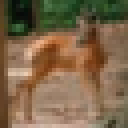

Image predicted as deer with confidence 0.36
y_hat[airplane] = 0.00
y_hat[automobile] = 0.00
y_hat[bird] = 0.09
y_hat[cat] = 0.08
y_hat[deer] = 0.36
y_hat[dog] = 0.18
y_hat[frog] = 0.15
y_hat[horse] = 0.14
y_hat[ship] = 0.00
y_hat[truck] = 0.00


In [52]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
un_normalize = lab_utils.UnNormalize((0.4914, 0.4822, 0.4465), 
                                     (0.2023, 0.1994, 0.2010))

network.eval()  # Important!

# Now predict the category using this trained classifier
for i in range(0, 5):
    img_id = random.randint(0, 10000)
    print('Image %d' % img_id)
    img, _ = valset[img_id]
    #predictions = F.softmax(network(Variable(img.unsqueeze(0)))) # CPU
    predictions = F.softmax(network(Variable(img.unsqueeze(0).cuda()))) # GPU
    predictions = predictions.data

    # Show the results of the classifier.
    lab_utils.show_image(lab_utils.tensor2pil(un_normalize(img)).resize((128, 128)));
    max_score, max_label = predictions.max(1)
    print('Image predicted as %s with confidence %.2f' % (classes[max_label[0]], max_score[0]))

    # Print out detailed predictions.
    for (i, pred) in enumerate(predictions.squeeze().tolist()):
        print('y_hat[%s] = %.2f' % (classes[i], pred))

### 7. Pytorch's pretrained Convolutional Neural Networks.

Pytorch has several pretrained Convnet models in the <u>Imagenet</u> Large Scale Visual Recognition Challenge (ILSVRC) dataset. The ILSVRC task contains <u>more than 1 million images</u> in the training set, and the number of labels is <u>1000</u>. 

Training a Convnet on this dataset takes often weeks on arrays of GPUs. Let's load one of such networks with 18 layers of depth, and try it in some images. Look below at how impressive is this neural network with so many layers and groups of layers, however most layers are still ReLU, Conv2d, and BatchNorm2d, with a few MaxPool2d, and one AvgPool2d and Linear at the end. There are also Resnet versions of depth size 34, 50, 101, and 152.

In [3]:
resnet = models.resnet18(pretrained = True)
print(resnet)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

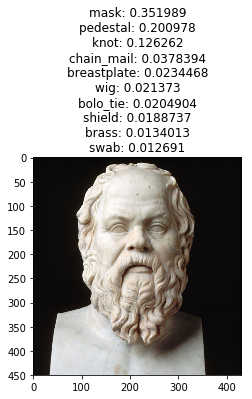

In [57]:
# 1. Define the appropriate image pre-processing function.
# --------------------------------------------------------

preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
# ---------------------------------

imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

# 3. Forward a test image of the toaster.
# ---------------------------------------

# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
#image = Image.open('test_image.jpg').convert('RGB')
image = Image.open('socrates.jpg').convert('RGB')

# Try your own image here. This is a picture of my toaster at home.
inputVar =  Variable(preprocessFn(image).unsqueeze(0))
predictions = resnet(inputVar)

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions)).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

In [ ]:
# I think the results here are interesting. 

### 8. Fine-tuning Resnet on CIFAR-10

Below "`Alexnet`" changed to `Resnet` based on dicussions on Piazza.

We will now use a pretrained network known as `Alexnet` on CIFAR-10 data, however there is a problem which is that `Alexnet` takes images in 224x224 resolution, and CIFAR-10 images are 32x32. So we will scale-up images in CIFAR-10 so that they work with `Alexnet`.


In [6]:
# Same transformations as before but we do not vectorize the images.
# Additionally we are scaling up images to 224x224 in order to use Resnet.
imgTransform = transforms.Compose([transforms.Scale((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])
trainset = CIFAR10(root='../data', train = True, transform = imgTransform)
valset = CIFAR10(root='../data', train = False, transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 64, 
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 64, 
                                        shuffle = False, num_workers = 0)

The code below will be extremely slow on a CPU, hours per epoch, and maybe a week to finish all epochs. 

For this part <u>you will need <b>GPU</b> nodes</u> in the cloud (AWS, Google Cloud) or your own GPU. Another thing, is that GPUs do not have a lot of memory so batch size 128 is also not going to be possible.

In [7]:
from tqdm import tqdm as tqdm
# Try this if the above gives trouble: 
#from tqdm import tqdm_notebook as tqdm

learningRate = 1e-3  # Single learning rate for this lab.

# Below trained to resnet
network = models.alexnet(pretrained = True)
network.fc = nn.Linear(2048, 10)  # CIFAR-10 has 10 classes not 1000.

#network = models.resnet18(pretrained= True)
#network.fc = nn.Linear(512, 2)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
12.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

24.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

44.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limi

In [8]:
#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)  
            
# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

Training epoch 0:  41%|████      | 318/782 [00:38<00:59,  7.79it/s, accuracy=38.3, loss=2.1] 

KeyboardInterrupt: 

## Lab Questions (10pts)

1) [2pts] In section 3 of this lab we implemented the ReLU activation function, and used it to train a two-layer neural network. Here please implement Sigmoid, and TanH:

$$\text{Sigmoid(x)} = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$$

$$\text{Tanh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

In [ ]:
# Sigmoid of x.
class nn_Sigmoid:
    def forward(self, x):
        # Forward pass.
        #sigmoid = x.exp() / (x.exp() + 1)
        #return sigmoid
        pass
    
    def backward(self, x, gradOutput):
        # Backward pass
        pass
        
# Hyperbolic tangent.
class nn_Tanh:
    def forward(self, x):
        # Forward pass.
        #tanh = (x.exp() - -x.exp) / (x.exp() - x.exp()) #??? the negative x's ???
        pass
    
    def backward(self, x, gradOutput):
        # Backward pass
        pass

2) [1pts] Our ReLU function makes things zero when they are less than zero. This is still the most widely used activation function used today but a variante called LeakyReLU has been proposed where a linear function close to zero is used instead. Here is the definition:

$$ \text{LeakyReLU}(x) = \begin{cases} 
      \beta x & x < 0 \\
      x & x \geq 0 
\end{cases}$$

where $\beta$ is usally a small value e.g. $\beta = 0.3$

In [ ]:
# class nn_ReLU(object):
#     # pytorch has an element-wise max function.
#     def forward(self, inputs):
#         outputs = inputs.clone()
#         outputs[outputs < 0] = 0
#         return outputs
    
#     # Make sure the backward pass is absolutely clear.
#     def backward(self, inputs, gradOutput):
#         gradInputs = gradOutput.clone()
#         gradInputs[inputs < 0] = 0
#         return gradInputs

In [4]:
# Sigmoid of x.
class nn_LeakyReLU:
    def __init__(self, beta = 0.3):
        self.beta = beta
    
    def forward(x):
        # Forward pass.
        outputs = x.clone()
        outputs[outputs < 0] = 0.3
        return outputs
        #pass
    
    def backward(x, gradOutput):
        # Backward pass
        gradInputs = gradOutput.clone()
        gradInputs[inputs < 0] = 0.3
        return outputs
        #pass

In [7]:
nn_LeakyReLU.forward(torch.FloatTensor(.2))

TypeError: torch.FloatTensor constructor received an invalid combination of arguments - got (float), but expected one of:
 * no arguments
 * (int ...)
      didn't match because some of the arguments have invalid types: ([31;1mfloat[0m)
 * (torch.FloatTensor viewed_tensor)
      didn't match because some of the arguments have invalid types: ([31;1mfloat[0m)
 * (torch.Size size)
      didn't match because some of the arguments have invalid types: ([31;1mfloat[0m)
 * (torch.FloatStorage data)
      didn't match because some of the arguments have invalid types: ([31;1mfloat[0m)
 * (Sequence data)
      didn't match because some of the arguments have invalid types: ([31;1mfloat[0m)


3) [3pts] Propose a new convolutional neural network that obtains at least 76% accuracy in the CIFAR-10 validation set. Show here the code for your network, and a plot showing the training accuracy, validation accuracy, and another one with the training loss, and validation loss (similar plots as in our previous lab). Included is below the LeNet implementation that you can use as a starting point.

<u>Public benchmarks on CIFAR-10</u>: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130

In [ ]:
def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True):
    
    training_accuracy_values = []
    validation_accuracy_values = []
    
    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            
            # Added
            # -----
            #if use_gpu:
                #loss = loss.cuda()

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
        accuracy = 100 * correct / counter
        training_accuracy_values.append(accuracy)
        training_loss_values.append(cum_loss)
        
        # Make a pass over the validation data.
        # -------------------------------------
        
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        accuracy = 100 * correct / counter
        validation_accuracy_values.append(accuracy)
        validation_loss_values.append(cum_loss)
        
    value_lists = [training_accuracy_values,validation_accuracy_values,training_loss_values,validation_loss_values]
    return value_lists

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def pytorch_model_results(training_values, validation_values, metric='accuracy'):

    # Plot of the loss for training and validation after every epoch
    # --------------------------------------------------------------
    
    if metric == 'accuracy':
        plot_title = 'Training and validation accuracy values after each epoch'
        plot_ylabel = 'Avg Accuracy'
    elif metric == 'loss':
        plot_title = 'Training and validation loss values after each epoch'
        plot_ylabel = 'Avg Loss'

    plt.figure(figsize=(8, 6))

    # training loss
    x = [i+1 for i in range(0, len(training_values)) ]
    y = training_values
    training_plot = 'b^--'
    plt.plot(x, y, training_plot)

    # validation loss
    y = validation_values
    validation_plot = 'r.--'
    plt.plot(x, y, validation_plot)

    # legend, and labels
    plt.legend(['Training','Validation'])
    plt.title(plot_title)
    plt.xlabel('Epoch count')
    plt.ylabel(plot_ylabel)
    plt.xticks(x)

    plt.show()

In [8]:
imgTransform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])
trainset = CIFAR10(root='../data', train = True, transform = imgTransform)
valset = CIFAR10(root='../data', train = False, transform = imgTransform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 256, 
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 256, 
                                        shuffle = False, num_workers = 0)

In [3]:
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
#     if use_gpu:
#         network = network.cuda()
#         criterion = criterion.cuda()
        
#     # Training loop.
#     for epoch in range(0, n_epochs):
#         correct = 0.0
#         cum_loss = 0.0
#         counter = 0

#         # Make a pass over the training data.
#         t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
#         network.train()  # This is important to call before training!
#         for (i, (inputs, labels)) in enumerate(t):

#             # Wrap inputs, and targets into torch.autograd.Variable types.
#             inputs = Variable(inputs)
#             labels = Variable(labels)
            
#             if use_gpu:
#                 inputs = inputs.cuda()
#                 labels = labels.cuda()

#             # Forward pass:
#             outputs = network(inputs)
#             loss = criterion(outputs, labels)

#             # Backward pass:
#             optimizer.zero_grad()
#             # Loss is a variable, and calling backward on a Variable will
#             # compute all the gradients that lead to that Variable taking on its
#             # current value.
#             loss.backward() 

#             # Weight and bias updates.
#             optimizer.step()

#             # logging information.
#             cum_loss += loss.data[0]
#             max_scores, max_labels = outputs.data.max(1)
#             correct += (max_labels == labels.data).sum()
#             counter += inputs.size(0)
#             t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

#         # Make a pass over the validation data.
#         correct = 0.0
#         cum_loss = 0.0
#         counter = 0
#         t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
#         network.eval()  # This is important to call before evaluating!
#         for (i, (inputs, labels)) in enumerate(t):

#             # Wrap inputs, and targets into torch.autograd.Variable types.
#             inputs = Variable(inputs)
#             labels = Variable(labels)
            
#             if use_gpu:
#                 inputs = inputs.cuda()
#                 labels = labels.cuda()

#             # Forward pass:
#             outputs = network(inputs)
#             loss = criterion(outputs, labels)

#             # logging information.
#             cum_loss += loss.data[0]
#             max_scores, max_labels = outputs.data.max(1)
#             correct += (max_labels == labels.data).sum()
#             counter += inputs.size(0)
#             t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

In [126]:
# def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True):
    
#     training_accuracy_values = []
#     validation_accuracy_values = []
    
#     training_loss_values = []
#     validation_loss_values = []
    
#     if use_gpu:
#         network = network.cuda()
#         criterion = criterion.cuda()
        
#     # Training loop.
#     for epoch in range(0, n_epochs):
#         correct = 0.0
#         cum_loss = 0.0
#         counter = 0

#         # Make a pass over the training data.
#         t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
#         network.train()  # This is important to call before training!
#         for (i, (inputs, labels)) in enumerate(t):

#             # Wrap inputs, and targets into torch.autograd.Variable types.
#             inputs = Variable(inputs)
#             labels = Variable(labels)
            
#             if use_gpu:
#                 inputs = inputs.cuda()
#                 labels = labels.cuda()

#             # Forward pass:
#             outputs = network(inputs)
#             loss = criterion(outputs, labels)
            
#             # Added
#             # -----
#             #if use_gpu:
#                 #loss = loss.cuda()

#             # Backward pass:
#             optimizer.zero_grad()
#             # Loss is a variable, and calling backward on a Variable will
#             # compute all the gradients that lead to that Variable taking on its
#             # current value.
#             loss.backward() 

#             # Weight and bias updates.
#             optimizer.step()

#             # logging information.
#             cum_loss += loss.data[0]
#             max_scores, max_labels = outputs.data.max(1)
#             correct += (max_labels == labels.data).sum()
#             counter += inputs.size(0)
#             t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
#         accuracy = 100 * correct / counter
#         training_accuracy_values.append(accuracy)
#         training_loss_values.append(cum_loss)
        
#         # Make a pass over the validation data.
#         # -------------------------------------
        
#         correct = 0.0
#         cum_loss = 0.0
#         counter = 0
#         t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
#         network.eval()  # This is important to call before evaluating!
#         for (i, (inputs, labels)) in enumerate(t):

#             # Wrap inputs, and targets into torch.autograd.Variable types.
#             inputs = Variable(inputs)
#             labels = Variable(labels)
            
#             if use_gpu:
#                 inputs = inputs.cuda()
#                 labels = labels.cuda()

#             # Forward pass:
#             outputs = network(inputs)
#             loss = criterion(outputs, labels)

#             # logging information.
#             cum_loss += loss.data[0]
#             max_scores, max_labels = outputs.data.max(1)
#             correct += (max_labels == labels.data).sum()
#             counter += inputs.size(0)
#             t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
#         accuracy = 100 * correct / counter
#         validation_accuracy_values.append(accuracy)
#         validation_loss_values.append(cum_loss)
        
#     value_lists = [training_accuracy_values,validation_accuracy_values,training_loss_values,validation_loss_values]
#     return value_lists

In [16]:
# ------------------------------------------------------
# Notes
# ------------------------------------------------------

# I added more conv layers, and changed their hyperparameters based on the following:
# https://arxiv.org/pdf/1412.6806v3.pdf

# Batch size: 64
# Momentum 0.3
# Weight decay - Without: 67%. With 0.0005: 70%

# Batch size: 256
# Accuracy: 44.9
# Momentum 0.9: 74%
# Learning rate 0.02: 77%, but best value was at 8/10 epochs
# Epochs 8: 

# -------------------------------------------------------------------------------------------

import time

t0 = time.time()

# ------------------------------------------------------
# Define Model
# ------------------------------------------------------

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 96, 3)
        self.conv2 = nn.Conv2d(96, 96, 3)
        
        self.conv3 = nn.Conv2d(96,192,3)
        self.conv4 = nn.Conv2d(192,192,3)
        
        # Linear layers.
        self.fc1 = nn.Linear(192*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 3, stride=2) # out: [16, 6, 14, 14]
        
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.max_pool2d(out, 3, stride=2) # out: [16, 192, 4, 4]
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# ------------------------------------------------------
# Train Model
# ------------------------------------------------------

network = MyNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0005)

train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 12, use_gpu=True)

# ------------------------------------------------------
# Time
# ------------------------------------------------------

t1 = time.time()
total = t1-t0

Validation epoch 11: 100%|██████████| 40/40 [00:01<00:00, 28.70it/s, accuracy=79.1, loss=0.694]


In [17]:
print(total/60)

2.459402883052826


In [18]:
# # Save model parameters
# # ---------------------
# name = 'near_80'
# # ---------------------
# dir_path = "../saved_models/"
# extension = '.pt'
# PATH = dir_path+name+extension
# torch.save(network.state_dict(), PATH)

# # Load
# #torch.load(PATH)

In [52]:
training_epoch = {}
validation_epoch = {}

training_epoch[0]    = {"accuracy":25.6, "loss":1.990}
validation_epoch[0]  = {"accuracy":42.4, "loss":1.570}
training_epoch[1]    = {"accuracy":47.2, "loss":1.430}
validation_epoch[1]  = {"accuracy":53.5, "loss":1.280}
training_epoch[2]    = {"accuracy":58.5, "loss":1.160}
validation_epoch[2]  = {"accuracy":62.2, "loss":1.040}
training_epoch[3]    = {"accuracy":67.3, "loss":0.927}
validation_epoch[3]  = {"accuracy":68.6, "loss":0.899}
training_epoch[4]    = {"accuracy":73.0, "loss":0.772}
validation_epoch[4]  = {"accuracy":72.5, "loss":0.778}
training_epoch[5]    = {"accuracy":76.6, "loss":0.669}
validation_epoch[5]  = {"accuracy":71.2, "loss":0.807}
training_epoch[6]    = {"accuracy":79.5, "loss":0.587}
validation_epoch[6]  = {"accuracy":76.8, "loss":0.688}
training_epoch[7]    = {"accuracy":82.7, "loss":0.495}
validation_epoch[7]  = {"accuracy":77.1, "loss":0.673}
training_epoch[8]    = {"accuracy":85.1, "loss":0.424}
validation_epoch[8]  = {"accuracy":78.4, "loss":0.682}
training_epoch[9]    = {"accuracy":87.2, "loss":0.366}
validation_epoch[9]  = {"accuracy":77.3, "loss":0.753}
training_epoch[10]   = {"accuracy":88.9, "loss":0.316}
validation_epoch[10] = {"accuracy":78.3, "loss":0.700}  
training_epoch[11]   = {"accuracy":90.8, "loss":0.260} 
validation_epoch[11] = {"accuracy":79.1, "loss":0.694}

training_loss_values = [training_epoch[i]["loss"] for i in list(training_epoch.keys())]
training_accuracy_values = [training_epoch[i]["accuracy"] for i in list(training_epoch.keys())]

validation_loss_values = [validation_epoch[i]['loss'] for i in list(validation_epoch.keys())]
validation_accuracy_values = [validation_epoch[i]['accuracy'] for i in list(validation_epoch.keys())]

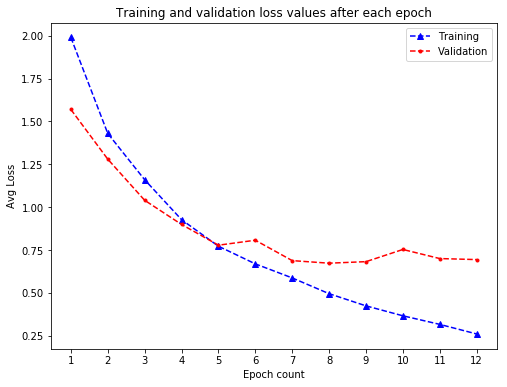

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot of the loss for training and validation after every epoch
# --------------------------------------------------------------

plt.figure(figsize=(8, 6))

# training loss
x = list(training_epoch.keys())
x = [i + 1 for i in x] # add 1 to each element for readability
y = training_loss_values
training_plot = 'b^--'
plt.plot(x, y, training_plot)

# validation loss
x = list(validation_epoch.keys())
x = [i + 1 for i in x] # add 1 to each element for readability
y = validation_loss_values
validation_plot = 'r.--'
plt.plot(x, y, validation_plot)

# legend, and labels
plt.legend(['Training','Validation'])
plt.title('Training and validation loss values after each epoch')
plt.xlabel('Epoch count')
plt.ylabel('Avg Loss')
plt.xticks(x)

plt.show()

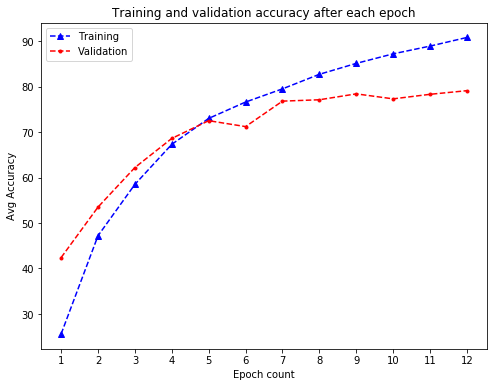

In [54]:

# Plot of the accuracy in training and validation after every epoch
# -----------------------------------------------------------------

plt.figure(figsize=(8, 6))

# training loss
x = list(training_epoch.keys())
x = [i + 1 for i in x] # add 1 to each element for readability
y = training_accuracy_values
training_plot = 'b^--'
plt.plot(x, y, training_plot)

# validation loss
x = list(validation_epoch.keys())
x = [i + 1 for i in x] # add 1 to each element for readability
y = validation_accuracy_values
validation_plot = 'r.--'
plt.plot(x, y, validation_plot)

# legend, and labels
plt.legend(['Training','Validation'])
plt.title('Training and validation accuracy after each epoch')
plt.xlabel('Epoch count')
plt.ylabel('Avg Accuracy')
plt.xticks(x)
plt.show()

4) [4pts] Train a Convolutional Neural Network on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. The training data has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. So please download the training, validation splits from the following dropbox link instead: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip?dl=0), or CS link: [cat_dogs.zip](http://www.cs.virginia.edu/~vicente/recognition/notebooks/cats_dogs.zip) . You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots.

In [13]:
# https://stackoverflow.com/questions/43441673/trying-to-load-a-custom-dataset-in-pytorch

# Using ResNet 18.
# Note: I'm not going to freeze the weights
# since our dataset n > 1000
# -----------------------------------------

resnet = models.resnet18(pretrained = True)

train_path = "../../data/datasets/cats_dogs/trainset"
val_path = "../../data/datasets/cats_dogs/valset"

import torchvision.datasets as dset

transform = transforms.Compose([transforms.Scale((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

trainset = dset.ImageFolder(train_path,transform=transform)
valset = dset.ImageFolder(val_path,transform=transform)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100.0%


In [14]:
trainLoader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = 128, 
                                          shuffle = True, 
                                          num_workers = 0
                                         )
valLoader = torch.utils.data.DataLoader(valset, 
                                        batch_size = 128, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )

In [13]:
print(resnet.fc)
resnet.fc = nn.Linear(512, 2) # Our dataset has 2 classes
print(resnet.fc)

Linear (512 -> 2)
Linear (512 -> 2)


In [14]:
import time

t0 = time.time()

# ------------------------------------------------------
# Retrain resnet on our dataset
# ------------------------------------------------------


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0005)
#optimizer = optim.SGD(resnet.parameters())

train_model(resnet, criterion, optimizer, trainLoader, valLoader, n_epochs = 4, use_gpu=True)

# ------------------------------------------------------
# Time
# ------------------------------------------------------

t1 = time.time()
total = t1-t0

Validation epoch 3: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s, accuracy=97.9, loss=0.066] 


### Optional

1) [3pts] For Q4 you get extra points if you use Resnet as in Section 7 but replace the fc layer at the end so that the model only predicts two variables (cat and dog). You will have to then re-train Resnet in this dataset. The idea is to use a model that has already been pre-trained on large task (ILSVRC), and re-train it (often called fine-tuning), on a smaller dataset. Present your code for the model, training output, plots, and example classifications on a few validations set images. Note: If you provide a model that does this in Q4, you directly get awarded 7pts in Q4 but for clarity provide the solution here instead if you plan to do this. Keep in mind that re-training Resnet on 20,000 images will probably still require GPU computing, and some significant computing time so start this early.

In [10]:
# I provided a model that does this in Q4. 

# My solution was to change the fully connected layer from size (512,1000) to (512,2) using the following:

# resnet.fc == nn.Linear(512, 2)


In [42]:
resnet = models.resnet18(pretrained = True)

# Transfer learning parameters
# ----------------------------

for param in resnet.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default

# create another linear layer
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# create softmax layer
#resnet.fc = nn.Softmax()    

In [44]:
import time

t0 = time.time()

# ------------------------------------------------------
# Retrain resnet on our dataset
# ------------------------------------------------------


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0005)
#optimizer = optim.SGD(resnet.parameters(), lr=0.2)

value_lists = train_model(resnet, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu=True)

# ------------------------------------------------------
# Time
# ------------------------------------------------------

t1 = time.time()
total = t1-t0

Validation epoch 4: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s, accuracy=97.7, loss=0.0563]

[95.105, 97.39, 97.57, 97.88, 97.71]
[97.44, 97.34, 97.46, 97.78, 97.74]
[26.867344645783305, 12.502515856176615, 10.940361141227186, 9.25950199784711, 9.840452501084656]
[3.1014434713870287, 2.903568534180522, 2.6280950256623328, 2.277261487208307, 2.2526766303926706]


In [45]:
print(total/60)

9.279356201489767


In [67]:
training_accuracy_values = [95.105, 97.39, 97.57, 97.88, 97.71]
validation_accuracy_values = [97.44, 97.34, 97.46, 97.78, 97.74]
training_loss_values = [26.867344645783305, 12.502515856176615, 10.940361141227186, 9.25950199784711, 9.840452501084656]
validation_loss_values = [3.1014434713870287, 2.903568534180522, 2.6280950256623328, 2.277261487208307, 2.2526766303926706]

In [68]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# def pytorch_model_accuracy(training_accuracy_values, validation_accuracy_values):

#     # Plot of the loss for training and validation after every epoch
#     # --------------------------------------------------------------

#     plt.figure(figsize=(8, 6))

#     # training loss
#     x = [i+1 for i in range(0, len(training_accuracy_values)) ]
#     y = training_accuracy_values
#     training_plot = 'b^--'
#     plt.plot(x, y, training_plot)

#     # validation loss
#     y = validation_accuracy_values
#     validation_plot = 'r.--'
#     plt.plot(x, y, validation_plot)

#     # legend, and labels
#     plt.legend(['Training','Validation'])
#     plt.title('Training and validation accuracy values after each epoch')
#     plt.xlabel('Epoch count')
#     plt.ylabel('Avg Accuracy')
#     plt.xticks(x)

#     plt.show()
    

# def pytorch_model_loss(training_loss_values, validation_loss_values):

#     # Plot of the loss for training and validation after every epoch
#     # --------------------------------------------------------------

#     plt.figure(figsize=(8, 6))

#     # training loss
#     x = [i+1 for i in range(0, len(training_loss_values)) ]
#     y = training_loss_values
#     training_plot = 'b^--'
#     plt.plot(x, y, training_plot)

#     # validation loss
#     y = validation_loss_values
#     validation_plot = 'r.--'
#     plt.plot(x, y, validation_plot)

#     # legend, and labels
#     plt.legend(['Training','Validation'])
#     plt.title('Training and validation loss values after each epoch')
#     plt.xlabel('Epoch count')
#     plt.ylabel('Avg loss')
#     plt.xticks(x)

#     plt.show()

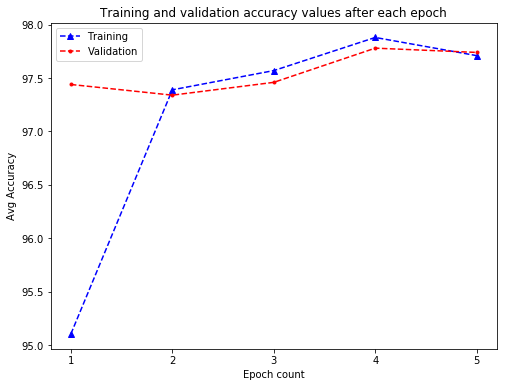

In [69]:
pytorch_model_accuracy(value_lists[0], value_lists[1])

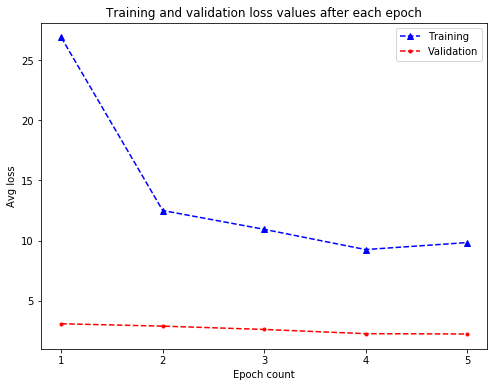

In [70]:
pytorch_model_loss(value_lists[3], value_lists[4])

2) [2pts] A simpler (less time consuming) approach to using a pre-trained CNN is to use it as a feature extractor. In this strategy we would use the Resnet network to compute "features" of the images, and then train a simple softmax classifier on top of those features. We could for instance remove the "fc" layer from the model, and use the 512-dimensional output of the network as our "features" for each image. Then we train a softmax classifier using these 512-dimensional vectors as inputs. Train such a classifier here for the dogs vs cats task, and present model, plots, and a few example classifications on the validation set. Note: In this task, since we only run the forward pass of Resnet once for each image, we might be able to get away doing this optional part without a GPU.

In [ ]:
# Below I will implement this by generating a discrete dataset from the output of the FeatureExtractor, and then
# training GBRT model (using the sklearn implementation). I wanted to do it this way, because I wanted to figure out
# how to get the tensor.gpu feature vector into a numpy format so that I could do other things down the road
# like performing TSNE on the resnet feature vector and then plotting the actual images so that you could see 
# how they align (part of something I'm thinking about for the final project). Down the road, I'd like to write
# a simple script that performs the feature extraction below, but where you can pass arguments determining the terminal
# layer in the FeatureExtractor.

In [18]:
resnet = models.resnet50(pretrained = True)

for param in resnet.parameters():
    param.requires_grad = False

trainLoader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = 1, 
                                          shuffle = True, 
                                          num_workers = 0
                                         )
valLoader = torch.utils.data.DataLoader(valset, 
                                        batch_size = 1, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )

In [120]:
# Using the feature extractor example provided by Vicente, with some slight modifications.
# ----------------------------------------------------------------------------------------
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.base_network = resnet.cuda() # need CUDA to use GPU
        #self.fc = 0
    
    # Additions
    #def classifier(self, feature_vector):
        #x = nn.Linear(feature_vectors.size()[0], n_classes)
        
    def forward(self, image):
        x = self.base_network.conv1(image)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        x = self.base_network.maxpool(x)

        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)
        x = self.base_network.avgpool(x)
        features = x.view(x.size(0), -1)
        
        return features

In [121]:
# Build new training dataset from our ResNet feature extractor
# ------------------------------------------------------------

#torch.cuda.comm.broadcast
#torch.cuda.set_device(gpus[0])

label_list = []
FeatureExtractor().eval()
for i, data in enumerate(trainLoader, 0):
        
        # get the inputs
        inputs, label = data
        inputs = inputs.cuda()
        train_feature_set = FeatureExtractor().forward(Variable(inputs))
        
        if i > 0:
            tensor_stack = torch.cat((tensor_stack, train_feature_set.data))
        else:
            tensor_stack = train_feature_set.data.clone()
            
        label_list.append(label[0])

In [232]:
pd_target = tensor_stack.cpu().numpy()
df = pd.DataFrame(pd_target)
df['class'] = label_list

# save training dataset
#df.to_pickle('../data/dogs_cats_training.csv')

In [242]:
# Train our model using GBRT
# Note: GBRT train time is very slow,
# but run time is really fast. 
# -----------------------------------

from sklearn.ensemble import GradientBoostingClassifier as gbrt

x_train = df.drop('class',1)
y_train = df['class']

import time
start = time.time()

seed = 1234

# This is as simple test, so not using cross validation with validation sets from the training set to tune the model.
clf = gbrt(random_state = seed)

# clf = GradientBoostingClassifier(learning_rate = 0.03,
#                                  max_depth = 4, 
#                                  min_samples_leaf = 10,
#                                  max_features = 'sqrt',
#                                  n_estimators = 300,
#                                  min_samples_split = 50,
#                                  random_state = seed
#                                 )

clf = clf.fit(x_train,y_train)

end = time.time()-start
#plot_model_overview(clf,x_test,y_test.user_megatype)
print("Modeling time: %s" % end)

Modeling time: 490.08495688438416


In [243]:
## Save model
#from sklearn.externals import joblib
#joblib.dump(clf, '../data/gbrt.model')

['../data/gbrt.model']

In [248]:
def plot_model_overview(model,x_in,y_in, digits=4):
    
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    predicted = model.predict(x_in)

    print('='*80)
    print(str(model))
    print('-'*80)

    print ('-'*21)
    print ("Classification Report")
    print ('-'*21)
    print(classification_report(y_in, predicted, digits=digits))
    print ('-'*32)
    print ("Confusion Matrix")
    print ('-'*32)
    print (confusion_matrix(y_in, predicted))

    from sklearn.metrics import accuracy_score
    print ('-'*25)
    print ("Accuracy Score")
    print ('-'*25)
    print (accuracy_score(y_in, predicted))

    from sklearn.metrics import f1_score
    print ('-'*25)
    print ("F1-Score")
    print ('-'*25)
    print (f1_score(y_in, predicted))
    print(' ')

In [249]:
# You should wrap this in a function or python script so that you can call it for something like TSNE+plot
label_list = []
FeatureExtractor().eval()
for i, data in enumerate(valLoader, 0):
        
        # get the inputs
        inputs, label = data
        inputs = inputs.cuda()
        feature_set = FeatureExtractor().forward(Variable(inputs))
        
        if i > 0:
            tensor_stack = torch.cat((tensor_stack, feature_set.data))
        else:
            tensor_stack = train_feature_set.data.clone()
            
        label_list.append(label[0])

In [250]:
pd_target = tensor_stack.cpu().numpy()
df = pd.DataFrame(pd_target)
df['class'] = label_list

# save training dataset
#df.to_pickle('../data/dogs_cats_validation.csv')

In [252]:
# NOTE: 0 corresponds to "Cat" and 1 corresponds to "Dog"
# Also note: Sklearn GBRT doesn't provide a convenient
# way to visualize the loss during training, so instead
# of providing the typical charts (like above), I will
# provide a model summary based on various metrics.
# -------------------------------------------------------

x_test = df.drop('class',1)
y_test = df['class']

# Test model on entire validation set
plot_model_overview(clf,x_test,y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)
--------------------------------------------------------------------------------
---------------------
Classification Report
---------------------
             precision    recall  f1-score   support

          0     0.9907    0.9804    0.9855      2500
          1     0.9806    0.9908    0.9857      2500

avg / total     0.9857    0.9856    0.9856      5000

--------------------------------
Confusion Matrix
--------------------------------
[[2451   49]
 [  23 2477]]
-------------------------
Accuracy Score
----------------

In [299]:
len(clf.estimators_)

100

Example of misclassification:
Predicted class: [1]
Actual class: 0


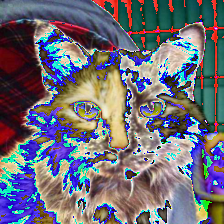

In [282]:
def tensor2pil(tensor):
    return transforms.ToPILImage()(tensor)

target = 0
print("Example of misclassification:")
print("Predicted class:", clf.predict(np.array(x_test.iloc[target,:]).reshape(1,-1)))
print("Actual class:", y_test[target])
tensor2pil(valLoader.dataset[target][0])

Example of correct classification:
Predicted class: [0]
Actual class: 0


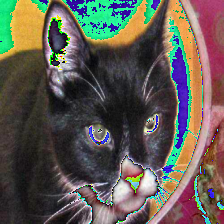

In [292]:
target = 1
print("Example of correct classification:")
print("Predicted class:", clf.predict(np.array(x_test.iloc[target,:]).reshape(1,-1)))
print("Actual class:", y_test[target])
tensor2pil(valLoader.dataset[target][0])

Example of correct classification:
Predicted class: [1]
Actual class: 1


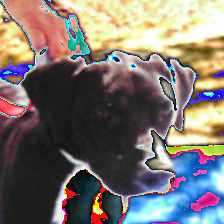

In [291]:
target = 2502

print("Example of correct classification:")
print("Predicted class:", clf.predict(np.array(x_test.iloc[target,:]).reshape(1,-1)))
print("Actual class:", y_test[target])
tensor2pil(valLoader.dataset[target][0])

In [302]:
clf.staged_predict(x_test.iloc[target,:])

<generator object GradientBoostingClassifier.staged_predict at 0x7fb3f04bba40>

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>